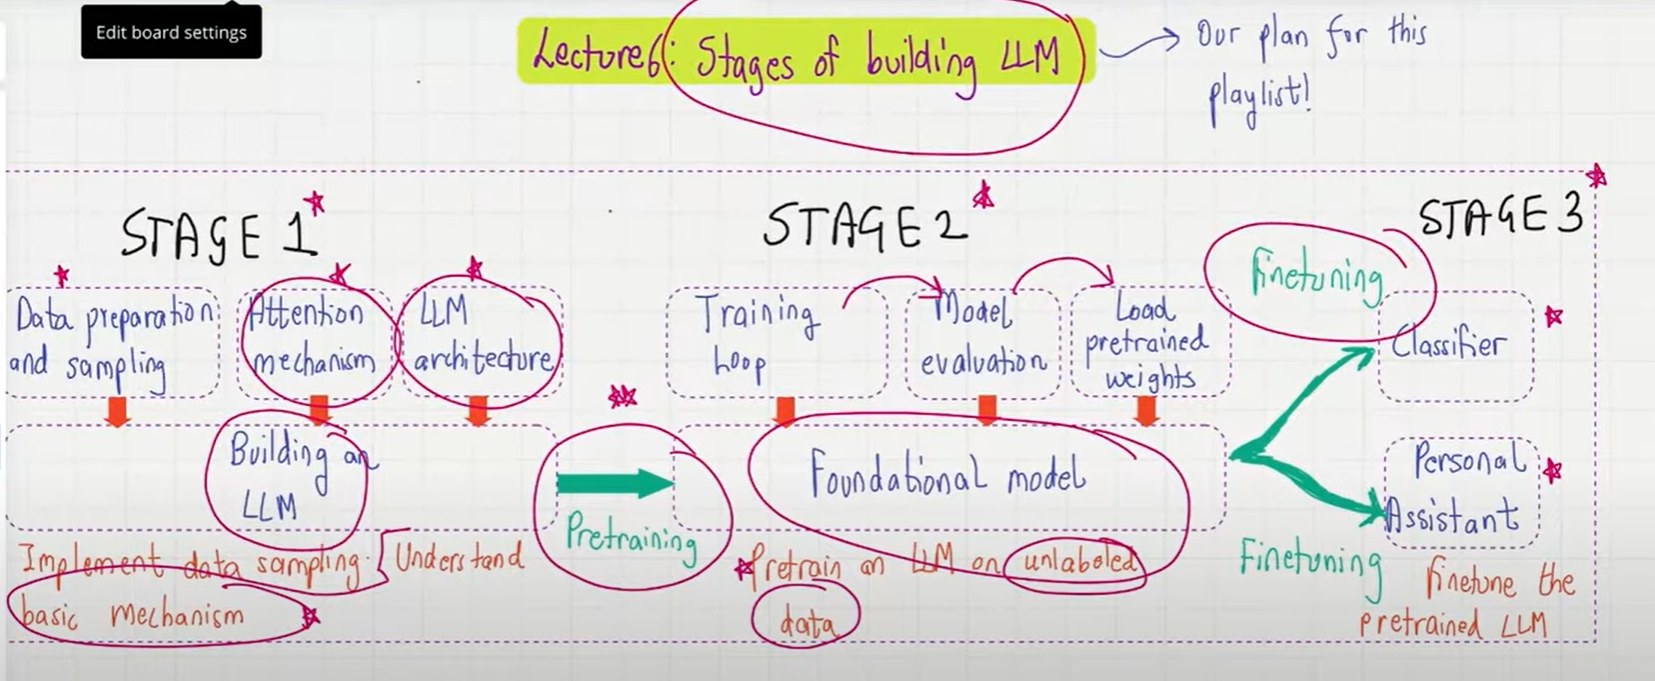

# Step 1: Creating Tokens

In [2]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Convert 20479 character short story into tokens

Python library re is used to split text into small words and it's split by white spaces, comma and full stops.

Example of text splitting 


In [3]:
import re

text = "Hello, world. This, is a test"
# [,.]|\s expression splits text by white spaces, comma and full stops
result = re.split(r'([,.]|\s)', text)

print(result)


['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test']


In [4]:
#result: ['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test']
#Remove redundant white space splits from result list (array)

result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test']


Keeping and removing white spaces is depends on reuirement. Eg. If python code is data source then it is adviced to keep white spaces

We may need other symbols like --,?! etc all as separate token

In [5]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


Apply above text splitting to raw text

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]

print(len(preprocessed))
print(preprocessed[:30])

4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


# Step 2: Creating Token IDs

Vocabulary: Split tokens sorted in alphabetical order. Each unique token is mapped to an unique integer called Token ID.

Convert Pre processed raw text list into set (To filter out unique tokens). Then sort it in alphabetical order.

In [7]:
all_words = sorted(set(preprocessed))
vocab_size =len(all_words)

print(vocab_size)

1130


Assign unique IDs (integer value) to each unique tokens and store it in dictionary (key value pair)

In [8]:
#enumerate(all_words) returns pairs of (integer, token) as it loops through the list.

vocab = {token: integer for integer, token in enumerate(all_words)}

#each unique tokens is assigned an integer and is stored in dicationary to build a vocabulary

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Later we want to convert the outputs of an LLM from numbers back into text, we also need a way to turn tokenID into text.
    For this, we can create an inverse version of vocbulary that maps toen IDs back to corresponding text/token.
</div>


### Lets implement a complete tokenizer class in python

<div style="background-color: #21CC77; color: black; padding: 10px">
    The class will have an encode method that splits text into tokens and carries out the string-to-integer mapping 
    In addition, we implement a decode method that carries out the reverse integer-to-string mapping to convert the token IDs into sample text.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Step 1: Store the vocabulary as a class attribute for access in the encode and decode methods <br/>
    Step 2: Create an inverse vocabulary that maps token IDs back to the original text tokens <br/>
    Step 3: Process input text into token IDs <br/>
    Step 4: Convert token IDs back into text <br/>
</div>

In [9]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        #create inverse vocabulary which can be used to convert token IDs into word tokens
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        #Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1',text)
        return text

Test SimpleTokenizerV1 class by taking the texts from "The Verdict" (data source)

In [10]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


<div style="background-color: #FF8A8A; color: black; padding: 10px">
    Here if we try to encode sentence which contains some words which are not present in vocabulary, encoder will throw error. Because it's not able to find tokenID for that word. So to build a vocabulary one needs a large amount of data. That's why training data used to train LLM is very large.
</div>

### Adding special context tokens
<div style="background-color: #21CC77; color: black; padding: 10px">
    In this section we'll modify this tokenizer to handle unknown words as "SimpleTokenizerV2". <br>
    To support two new tokens, <|unk|> and <|endoftext|>.
</div>

<div style="background-color: #21CC77; color: black; padding: 10px">
    When working with multiple text sorces, we add <|endoftext|> token between these texts.
    These <|endoftext|> tokens act as a markers, signaling the start or end of a particular segment.
    This leads to more effective processing and understanding by the LLM.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    We can modify the tokenizer to use an <|unk|> token if it encounters a word that is not part of the vocabulary. </br>
    </br>
    Furthermore, we add a token between unrelated texts (<|endoftext|> token). </br>
    </br>
    For example, when training GPT-like LLM on multiple independent documnets or books, it is common to insert a token before each document or book that follows a previous text source.
</div>

<div style="background-color: #21CC77; color: black; padding: 10px">
    Let's now modify the vocabulary to include these two special tokens, by adding these to the list of all uniue words that we created in the previous section.
</div>

In [11]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [12]:
len(vocab.items())

1132

<div style="background-color: #21CC77; color: black; padding: 10px">
    In previous section, vocabulary size was 1130 and no vocabulary size is 1132 because we've added two additional tokens.
<div>

<div style="background-color: #21CC77; color: black; padding: 10px">
    Now we'll implement simple text tokenizer that handles unknon words
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Step 1: replace unknown words by <|unk|> token. <br/>
    Step 2: Replace spaces before the specified punctuations <br/>
</div>

In [13]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        #create inverse vocabulary which can be used to convert token IDs into word tokens
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" 
            for item in preprocessed
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        #Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1',text)
        return text
        

In [14]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terrace of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terrace of the palace.


In [15]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 983, 722, 988, 1131, 7]

In [16]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terrace of the <|unk|>.'

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    In above example "Hello" and "Palace: words were unknown or were not part of dictionary. So if we encode that text, for that unlnown words we'll get token id of <|unk|> token. And then if we decode by tokenIDs, we'll get <|unk|> token for those words and it'll not throw error like before. SO that's how we handled unknown words.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    So far, we have discussed tokenization as an essential step in processing text as input to LLMs. Depending on the LLM, some  researchers also consider additioanl tokens such as the following: </br>
    </br>
    [BOS] (beginning of sequence): This token marks the start of a text. It signifies to the LLM where a piece of context begins.</br>
    </br>
    [EOS] (end of sequence): This tokenis positioned at the end of a text, and is especially useful when concatenating multiple unrelated texts, similar to <|endoftext|>. For instance, when combining two different Wikipedia articles or books, teh [EOS] token indicates where one article ends and the next one begins.</br>
    </br>
    [PAD] (padding): When training LLMs with batch size larger than one, the batch might contain texts of varying lengths. To ensure all texts have same length, the shorter texts are extended or "padded" using the [PAD] token, up to the length of the longest text in the batch.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Note that the tokenizer used for GPT models does not need any of these tokens mentioned above but only uses an <|endoftext|> token for simplicity.</br>
    </br>
    The GPT model tokenizer also does not use <|unk|> token for out of vocabulary words. Instead, GPT model use a byte pair encoding tokenizer, which breaks down words into subword units.
</div>

# Byte Pair Encoding (BPE)

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Types of Tokenization:</br>
    </br>
    1. Word based tokenization: Split sentence into words as it apprears in sentence.</br>
    2. Character based tokenization: Split sentence into singular characters from sentence.</br>
    3. Sub word based tokenization: Split words of sentence into sub words.</br>
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    <h3>Sub word based tokenization</h3>
    Rule 1: Do not freuently used words into smaller subwords</br>
    Rule 2: split the rare words into smaller, meaningful subwords.</br>
    eg. "boy" should not be split. "boys" should be split into "boy" and "s"</br>
    </br>
    Advantages: </br>
    1. The subword splitting helps the model learn that different words with same root word as "toke" like "tokens" and "tokenizing" are similar in meaning.</br>
    2. It also helps the model learn that "tokenization" and "modernization" are made up of different root words but have the same suffix "ization" and are used in same syntactic situation.</br>
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    <b>BYTE PAIR ENCOING (BPE)</b> is a subword based  tokenization algorithm.
    </br>
    Most common pair of consecutive bytes of data is replaced with a byte that does not occur in data.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Let's take an example:</br>
    Original data: aaabdaaabac</br>
    (a) The byte pair 'aa' occurs the most: We will replace it with Z as Z does not occur in the data. </br>
    (b) Compressed data 'ZabdZabac'.<br>
    (c) The next common byte pair is 'ab'. We will replace this by 'Y'.</br>
    (d) Compressed data 'ZYdZYac'. Only byte pair left is 'ac' as it does not gets repeated</br> 
    (e) here 'ZY' is repeating byte pair so it can be replaced by W. Further encoding: 'WdWac' 
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    <h5>Use of BPE in LLM</h5>
    (a) BPE ensures that most common words in vocabulary are represented as a single token, while rarewords are broken down into two or more    subword tokems.</br>
    </br>
    (b) Let's take an example.</br>
    </br>
    --> here is the dataset of words:</br>
    --> { "old":7, "older":3, "finest":9, "lowest":4 }</br>
    </br>
    --> Preprocessing: We need to add end token <|/w|> at the end of each word</br>
    --> { "old<|/w|>":7, "older<|/w|>":3, "finest<|/w|>":9, "lowest<|/w|>":4 } (remove || from <|/w|>, || is added because HTML is use for styling ) </br>
    --> Now split wwords into characters and count their freuency</br>
    --> { <|/w|>:23, o:14, l:14, d:10, e:16, r:3, f:9, i:9, n:9, s:13, t:13, w:4 }</br>
    </br>
    (c) Next step in BPE algorith is to look for most frequent pairing. Merge them and perform the same iteration again and again until we reach the token limit or iteration limit.</br>
    </br>
    --> Iteration 1: Start with the most common token "e". Most common byte pair starting with "e" is "es".</br>
    --> { <|/w|>:23, o:14, l:14, d:10, e:(16-13=3), r:3, f:9, i:9, n:9, s:(13-13=0), t:13, w:4, es:(9+4=13) }</br>
    </br>
    --> Iteration 2: Merge the tokens "es" and "t" as they have appeared 1 times in our database. </br>
    --> { <|/w|>:23, o:14, l:14, d:10, e:3, r:3, f:9, i:9, n:9, s:0, t:(13-13=0), w:4, es:(13-13=0), est:13 }</br>
    </br>
    --> Iteration 3: "est<|/w|>" token appears 13 time. </br>
    --> { <|/w|>:(23-13=10), o:14, l:14, d:10, e:3, r:3, f:9, i:9, n:9, s:0, t:0, w:4, es:0, est:(13-13=0), est<|/w|>:13 }</br>
    </br>
    --> Iteration 4: "o" and "l" has appended 10 times. </br>
    --> { <|/w|>:10, o:(14-10=4), l:(14-10=4), d:10, e:3, r:3, f:9, i:9, n:9, s:0, t:0, w:4, es:0, est:0, est<|/w|>:13, ol:(7+3=10)  }</br>
    </br>
    --> Iteration 5: "ol" and "d" has appended 10 times. </br>
    --> { <|/w|>:10, o:4, l:4, d:(10-10=0), e:3, r:3, f:9, i:9, n:9, s:0, t:0, w:4, es:0, est:0, est<|/w|>:13, ol:(10-10=0), old:10  }</br>
    </br>
    --> Iteration 6: "ol" and "d" has appended 10 times. </br>
    --> { <|/w|>:10, o:4, l:4, d:0, e:3, r:3, f:9, i:9, n:9, s:0, t:0, w:4, es:0, est:0, est<|/w|>:13, ol:0, old:10  }</br>
    </br>
    --> "f", "i", "n" appears 9 times. but we just have one word with these characters. So, we are not merging them</br>
    </br>
    --> Let's remove remove tokens with zero count.</br>
    -->Final Vocabulary: { <|/w|>:10, o:4, l:4, e:3, r:3, f:9, i:9, n:9, w:4, est<|/w|>:13, old:10  }</br>
    </br>
    </br>
    The stopping criteria can either be the token count or the number of iteration
<div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    The sub word based tokenization solves the out of vocabulary problem, managable vocabulary and also retaind meaning of root words. 
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Implementing BPE from scratch is quite difficult. So we will use "tiktoken" python library which is also used by OpenAI models
</div>

In [17]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.11.0


<div style="background-color: #21CC77; color: black; padding: 10px;">
    Once installed, we can initialize BPE tokenizer from tiktoken as follows:
</div>

In [18]:
tokenizer = tiktoken.get_encoding("gpt2")

<div style="background-color: #21CC77; color: black; padding: 10px;">
    The usage of tokenizer is similar to SimpleTokenizerV2 we implemented previously an encode method:
</div>

In [19]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


<div style="background-color: #21CC77; color: black; padding: 10px;">
    We can convert toen IDs back into text using decode method, similar to SimpleTokenizerV2:
</div>

In [20]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    <h5>Takeaways</h5>
    1. Token ID of of <|endoftext|> token is 50256 which is largest. So Vocabulary size BPE tokenizer uses is 50255. </br>
    2. BPE tokenizer can handle unknown words like "someunknownPlace". The reason this tokenizer achieves withous "<|unk|> token is that unknown words (word which are not in vocabulary) are broken down into smaller subwords units or even individual character.
</div>

In [21]:
# An example how BPE tokenizer acts with unknown words

integers = tokenizer.encode("Akwirw ier")
print(integers)

strings = tokenizer.decode(integers)
print(strings)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


# Creating Input-Target Pairs

<div style="background-color: #21CC77; color: black; padding: 10px;">
    In this section we implement a data loader that fetches the input-target pairs using sliding window approach.
</div>


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    - Given the text sample, extract input block as subsamples that serve as input to the LLM. <br>
    - The LLM prediction task during training is to predict the next word that follows input block. <br>
    - During thetraining, we mask out all words that are past the target. <br>
    <br>
    For example, sample text: "LLMs learn to predict one word at a time" <br>
    while training <br>
    Iteration i: <span style="background-color: #c21fdb">LLMs learn to predict </span> <span style="background-color: #ad8e53">one </span> word at a time.<br> <br>
    Iteration i+1: <span style="background-color: #c21fdb">LLMs learn to predict one </span> <span style="background-color: #ad8e53">word </span> at a time.<br>
    <br>
    Here "LLMs learn to predict" acts as  an input block and "one" acts as target word. Other words in sentence are masked which are not visible to LLM. <br>
    In each iteration input block is extended by one word and then next word in sentence acts as target.
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    To get started, we will first toenize the whole "The Verdict" short story we worked with earlier using BPE encoding
</div>

In [22]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Executing above code will return 5145, the total number of tokens in the training set, after applying the BPE tokenizer.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Next, we extract the first 50 tokens from the dataset for demonstration purpose as it results in a slightly more interesting text passage in the next step: 
</div>

In [23]:
enc_sample = enc_text[50:]
print(enc_sample)

[290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536, 5469, 438, 14363, 938, 4842, 1650, 353, 438, 2934, 489, 3255, 465, 48422, 540, 450, 67, 3299, 13, 366, 5189, 1781, 340, 338, 1016, 284, 3758, 262, 1988, 286, 616, 4286, 705, 1014, 510, 26, 475, 314, 836, 470, 892, 286, 326, 11, 1770, 13, 8759, 2763, 438, 1169, 2994, 284, 943, 17034, 318, 477, 314, 892, 286, 526, 383, 1573, 11, 319, 9074, 13, 536, 5469, 338, 11914, 11, 33096, 663, 4808, 3808, 62, 355, 996, 484, 547, 12548, 287, 281, 13079, 410, 12523, 286, 22353, 13, 843, 340, 373, 407, 691, 262, 9074, 13, 536, 48819, 508, 25722, 276, 13, 11161, 407, 262, 40123, 18113, 544, 9325, 701, 11, 379, 262, 938, 402, 1617, 261, 12917, 905, 11, 5025, 502, 878, 402, 271, 10899, 338, 366, 31640, 12, 67, 20811, 1, 284, 910, 11, 351, 10

<div style="background-color: #21CC77; color: black; padding: 10px;">
    One of the most intutive ways to create the input-target pairs for the next word prediction task is to create two variables, x and y, where x contains the input token and y contains the targets, which ae the inputs shifted by 1:
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    The context size determines how many tokens are included in the input
<div>

In [24]:
context_size = 4 #length of the input
#The context_size of 4 means that the model is trained to look at a sequence of 4 words (or tokens) to predict next ord in the sequence
#the input x is the first [1, 2, 3, 4], and the target y is the next 4 tokens [2, 3, 4, 5]

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


<div style="background-color: #21CC77; color: black; padding: 10px;">
    Processing the inputs along with the targets, which are the inputs shifted by one position, we can then create the next word prediction tasks as follows.
</div>

In [25]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "----->", desired)

[290] -----> 4920
[290, 4920] -----> 2241
[290, 4920, 2241] -----> 287
[290, 4920, 2241, 287] -----> 257


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Everything left of the arrow (----->) refers to the input an LLM would receive, and the tokenID on the right of the array represents the target tokenID that the LLM is supposed to predict.
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    For illustration purpose, let's repeat the previous code but convert the token IDs into text:
</div>

In [26]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "----->", tokenizer.decode([desired]))

 and ----->  established
 and established ----->  himself
 and established himself ----->  in
 and established himself in ----->  a


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    We've now created the input-target pairs that we can turn into use for the LLM training upcoming chapter.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    There's only one more task before we can turn the tokens into embeddings: implementing an efficient data loader that iterates over the input dataset and returns the inputs and targets as PyTorch tensors, which can be thought as multidimensional arrays.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    In particular, we are interested in returning two tensors an input tensor containing the text that the LLM sees and a target tensor that includest the targets for the LLM to predict.
</div>

### Implementing a Data Loader

<div style="background-color: #21CC77; color: black; padding: 10px;">
    For the efficient implementation, we will use PyTorch's built-in Dataset and DataLoader classes.
</div>

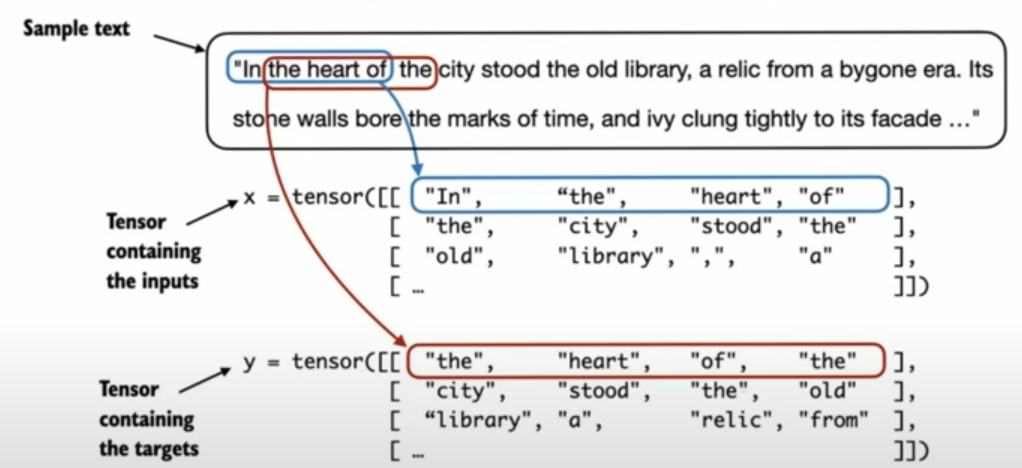

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    To implement efficient dataloaders, we collect inputs in a tensor x, where each row represents one input context. The second tensor y contains the corresponding prediction targets (next words), which are created by shifting the input by one position.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Step 1: Tokenize the enire text<br>
    Step 2: Use a sliding window to chunk the book into overlapping seuence of max_length<br>
    Step 3: Return the total number of rows in the dataset<br>
    Step 4: Return a single row from dataset
</div>

In [27]:
from torch.utils.data import Dataset, DataLoader
import torch

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        #Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0,len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1: i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    The GPTDatasetV1 class in listing 2.5 is based on the PyTorch Dataset class.<br>
    <br>
    It defines how individual rows are fetched from the dataset.<br>
    <br>
    Each row consists of number of token IDs (based on a max_length) assigned to an input_chunk tensor.<br>
    <br>
    The target_chunk tensor contains the corresponding targets.<br>
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    The following code will use the GPTDataverseV1 to load the inputs in batches via a PyTorch DataLoader.
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Step 1: Initialize the tokenizer<br>
    Step 2: Create Dataset<br>
    Step 3: drop_last=True drops the last if it is shorter than the specified batch_size to prevent loss spikes during training<br>
    Step 4: The number of CPU processes to use for preprocessing 
<div>

In [28]:
import tiktoken
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create Dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    To return input and output tensors DataLoader calls __getitem__ function of GPTDatasetV1.
<div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4,<br>
    <br>
    This will develop an intuition of how the GPTDataverseV1 class and the create_dataloader_v1 function work together:
<div>

In [29]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Convert dataloader into a Python iterator to fetch the next entry via Python's buil-in next() function
<div>

In [30]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=2, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

PyTorch version: 2.8.0+cpu
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[2885, 1464, 1807, 3619]]), tensor([[1464, 1807, 3619,  402]])]


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    The first_batch variable contains to tensors: the first tensor stores the input token IDs, and the second tensor stores the target token IDs<br>
    <br>
    Since the max_length is set to 4, each two tensors contains 4 token IDs.<br>
    <br>
    Note that an input size of 4 is relatively small and only chosen for illustration purpose. It is common to train LLMs with input 
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Meaning of stride:<br>
    Stride=1: Input tensors - tensor([[  40,  367, 2885, 1464]]) , tensor([[ 367, 2885, 1464, 1807]]) <br>
    Stride=2: Input tensors - tensor([[  40,  367, 2885, 1464]]) , tensor([[2885, 1464, 1807, 3619]])<br>
    Stride=4: Input tensors - tensor([[  40,  367, 2885, 1464]]) , tensor([[1807, 3619,  402,  271]])<br>
    <br>
    Stride setting dictates the number of positions the inputs shifts across batches, emulating a sliding window approach
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Batch size of 1, such as e have sampled from the data so far, are useful for illustration purpose.<br>
    In deep learning, Small batch size reuires less memory during training but lead to more noisy model updates.<br>
    Just like in regular deep learning, the batch size is a trade-off and hyperparameter to experiment ith when training LLMs.
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Increasing batch size will give input and output tensors size will be more
<div>

In [31]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print(inputs)
print(targets)

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Note that we increase stride to 4. This is to utilize the data set fully (we don't skip a single word) but also avoid overlap betwween the batches, since more overlap could lead to increased overfitting.
<div>

# Token Embedding

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    To calculate vectors of token IDs, first embedding layer weight matrix is created.<br>
    While GPT-2 training, tokens were converted into 768 dimensional vectors.<br>
    So the size of weight matrix used for GPT-2 was 50257*768.
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Steps to create token embedding for LLM.<br>
    <ul>
        <li>Initialize embedding weights with random values. i.e all 50257*768 blocks are initialized with random values.</li>
        <li>This initialization serves as the starting point of LLM learning purpose.</li>
        <li>The embedding weights are optimized as part of LLM training process</li>
        <li>Vocabulary (Sorted alphabetically) token IDs are converted into embdedding vectors.</li>
        <li>The embedding layer is a lookup operation that retrieves rows from the embedding layer eight matrix using token ID.</li>
    </ul>
<div>

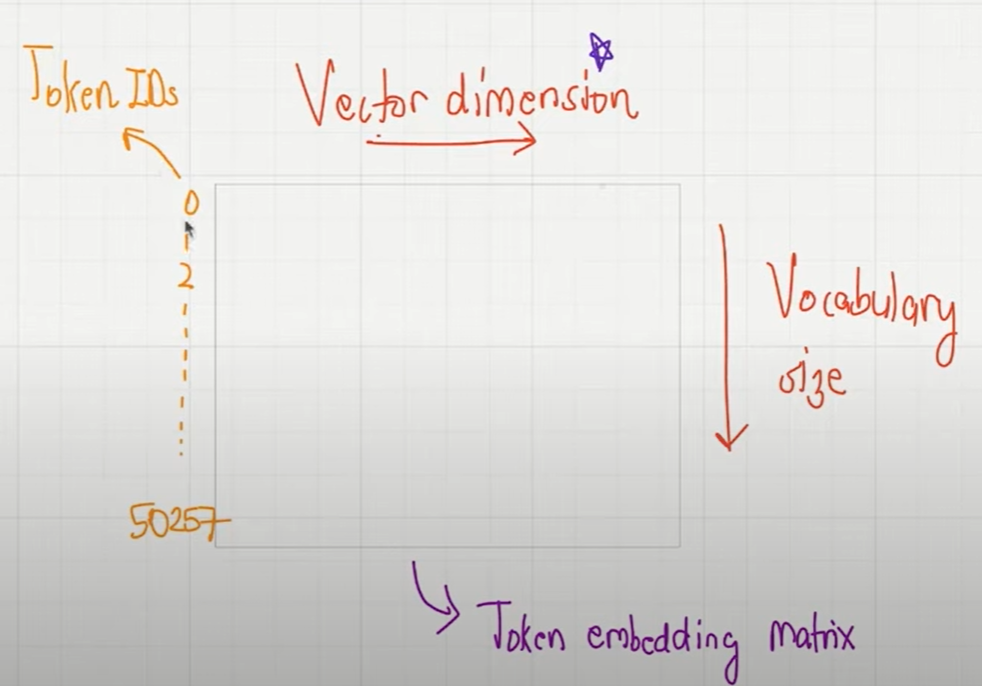

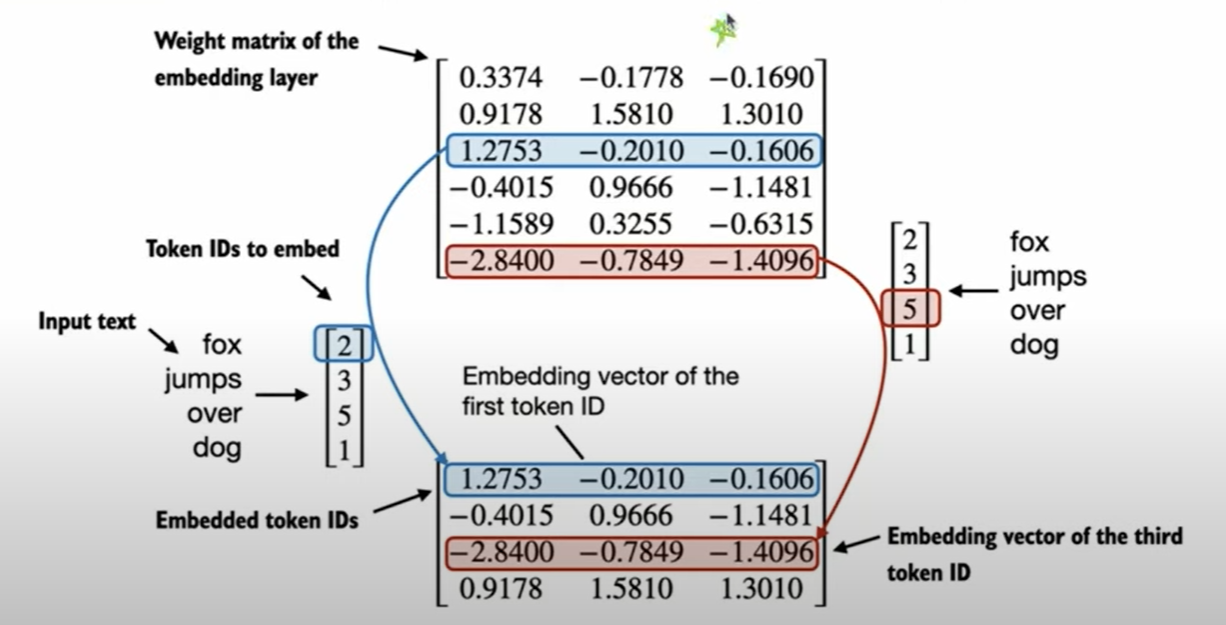

In [32]:
#Suppose we have the tensor of input IDs
input_ids = torch.tensor([2, 3, 5, 1])

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    For the sake of simplicity and illustration purposes, suppose e have a small vocabulary of only 6 words (instead of the 50,257 words in the BPE tokenizer vocabulary), and we want to create embedding size (in GPT-, the embedding size is 12,288 dimensions)
<div>

In [33]:
#Using the vocab_size and output_dim, we can initiate an embedding layer in PyTorch, setting the random seed to 123 for 
# reproducibility purpose
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
#initialize vector matrix in random manner as embedding layer matrix
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    We can see that eight matric of the embedding layer contains small, random values. The values are optimized during LLM training as part of the LLM optimization itself, as we see in upcoming chapters. We can see that the weight matrix has 6 rows and 3 columns. There is one row for each the sixpossible tokens in the vocabulary. ANd there is one columnsfor each of the 3 embedding dimension.
<div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    After we instantiated the embedding layer, let's now apply it to a token ID to obtain the embedding vector.
<div>

In [34]:
#Fetching vector for any token ID
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    If we compare the embedding vector for token ID 3 to the previous embedding matrix, we see that it is identical to the 4th row (Python starts with a zero index, so it's the row corresponding to index 3). <b>In other words, the embedding layer is essentially a look-up operation that retrieves rows from the embedding layer's weight matrix via a token ID.</b>
<div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    Previously, we have seen how to convert a single token ID into a three-dimensional embedding vector. Let's now apply that to all four input IDs we defined earlier (torch.tensor([2, 3, 5, 1])):
<div>

In [35]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Each row in this output matrix is obtained via a lookup operation from the embedding weight matrix
<div>

# Positional Embeddding

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    Two sentences: "The cat sat on the mat", "On the mat the cat sat"<br>
    In these sentences "cat" word is common and at different positions. But since tokenID for both "cat" is the same, embedding will be the same. Which may change meaning of token as positions of word is also important while capturing meanings of different sentences.<br>
    That's where positional embedding comes in picture.
<div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    There are two types of positional embedding: Absolute and Relative <br>
    <br>
    <b>Absolute</b> : For each position in input sequence, a unique embedding is added to the token's embedding to convey it's exact location <br>
    <u>Note</u>: The positional vectors have the same dimension as the original token embedding.<br>
    <br>
        
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    <b>Relative</b> : The emphasis is on the relative position or distance between tokens. The model learns the relationships in terms of "how far apart" rather than at which exact position.<br>
    <u>Advantage</u> : Model can generalize better to sequence of varying lengths even if it has not seen such lengths during training.
<div>


Positional Embedding :
(Token embeddings are same for illustration purpose, actually for each word embeddings are diffrent)
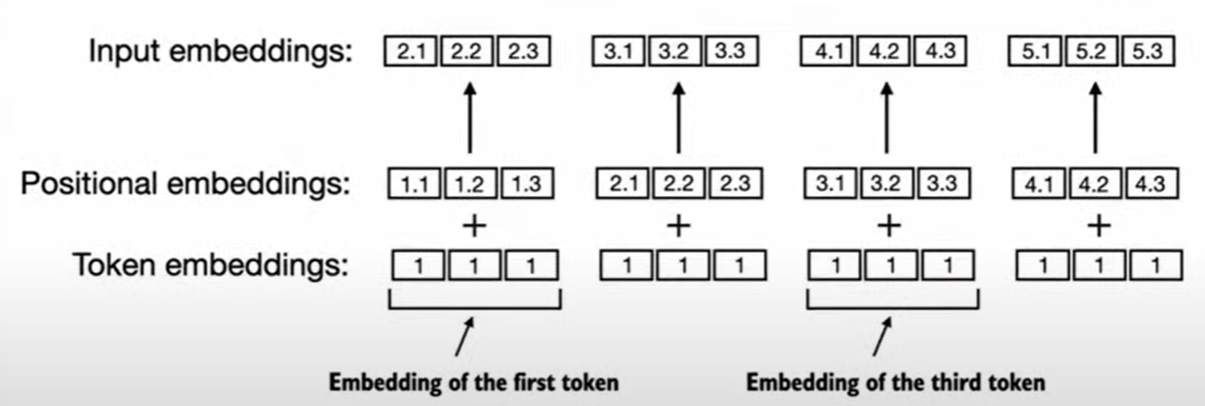

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Both types of positional encoding enables LLM to understand the order and relationship between tokens, ensuring more accurate and context aware predictions.<br>
    
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    The choice between the two depends onspecific application and the nature of dara being processed.<br>
    <br>
    <b>Absolute</b> : Suitabke when fixed order of token is crucial, such as seuence generation.<br>
    <b>Relative</b> : Suitable for tasks like language modeling over long sequence, where the same phrase can appear in defferent part of the sequence.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    Open AI's GPT model use absolute positional embeddings that are optimized during the training process. This optimization is part of the model training itself.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    Previously, we focused on very small embedding sizes in this chapter for illustration purposes.<br>
    We now consider more realistic and useful embedding sizes and encode the input tokens into a 256-dimensional vector representation. <br>
    This is smaller than what the original GPT-3 model used (in GPT-3, the embedding size is 12,288 dimensions) but still reasonable for experimentation. <br>
    Furthermore, we assume that the token IDs were created by the BPE tokenizer that we implemented earlier, which has a vocabulary size of 50,257:<br>
</div>

In [40]:
vocab_size = 50257
output_dim = 256

#initialize vector matrix in random manner as embedding layer matrix
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    Using the token_embedding_layer above, if we sample data from the data loader, we embed each token in each batch into a 256-dimensional vector. If we have a batch size of 8 with four tokens each, the result will be an 8 x 4 x 256 tensor.
</div>

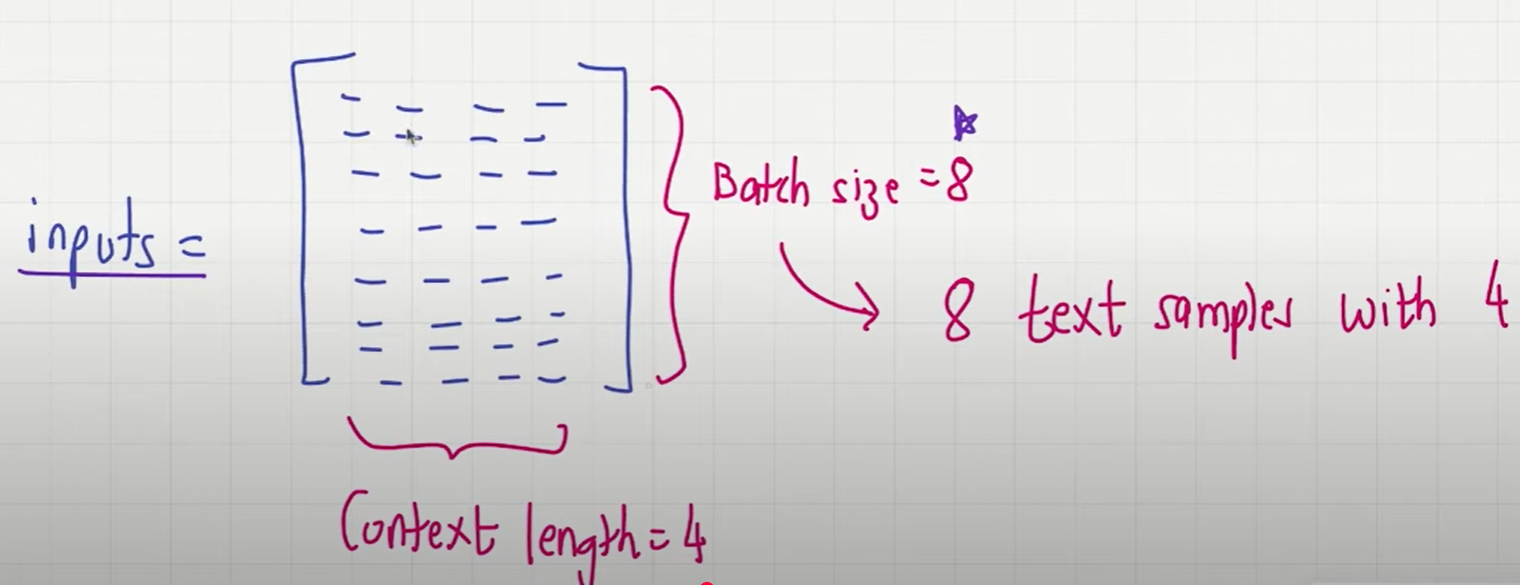

<div style="background-color: #B8B8FF; color: black; padding: 10px;"> 
    Each row contains 4 tokenIDs which acts as input to LLM to predict next word.
</div>

In [37]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length,shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [38]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
As we can see, the token ID tensor is 8x4-dimensional, meaning that the data batch consists of 8 text samples with 4 tokens each.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Let's now use the embedding layer to embed these token IDs into 256-dimensional vectors:
</div>

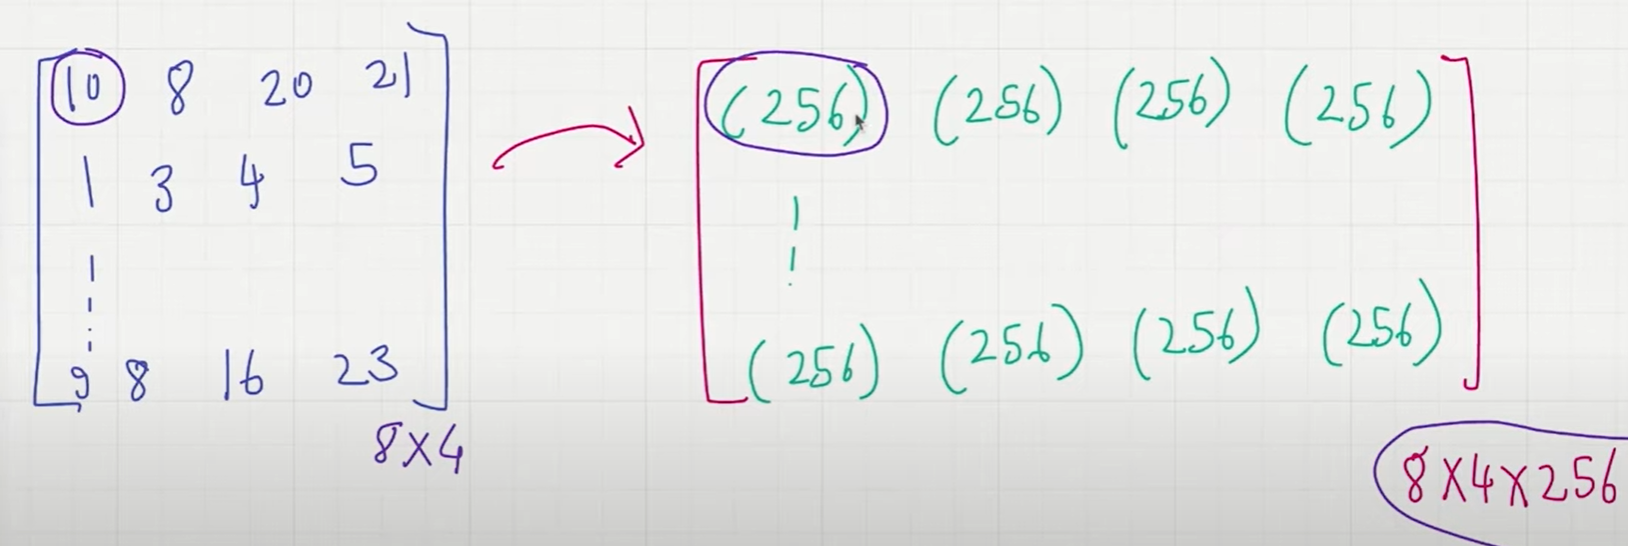

In [ ]:
token_embeddings = 1h(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    As we can tell based on the 8x4x256-dimensional tensor output, each token ID is now embedded as a 256-dimensional vector.
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    <b>Create another embedding layer for positioonal embedding</b><br>
    <br>
    At one time maximum input size is 4 here. which means that LLM is going to predict next word based on 4 previous tokens. So we need to encode only 4 positions. So positional embedding layer matrix size is <b>context_length*vector_dimensions</b> (4*256 here)
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    For a GPT model's absolute embedding approach, we just need to create another embedding layer that has the same dimension as the token_embedding_layer:
</div>

In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [51]:
# Generate the 4 positional embedding vectors from positional embedding matrix
# torch.arange(max_length) returns a tensor according to max_length (context_length) of inputs tensor
# In this case torch.arange(max_length) = [0, 1, 2, 3]
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)
print(pos_embeddings)

torch.Size([4, 256])
tensor([[-1.8088,  0.3850, -0.7622,  ...,  1.7244, -1.0515, -0.1369],
        [-0.5936,  0.6357,  0.3480,  ..., -0.2135, -0.7391, -1.1205],
        [-0.1304,  0.3446,  1.8986,  ..., -0.0329,  1.2266, -0.1704],
        [-0.3071, -0.5171,  1.1883,  ..., -0.7798, -0.1055, -0.5782]],
       grad_fn=<EmbeddingBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    As shown in the preceding code example, the input to the pos_embeddings is usually a placeholder vector torch.arange(context_length), which contains a sequence of numbers 0, 1, ..., up to the maximum input length − 1.<br>
    The context_length is a variable that represents the supported input size of the LLM. <br>
    Here, we choose it similar to the maximum length of the input text. <br>
    In practice, input text can be longer than the supported context length, in which case we have to truncate the text.<br>
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    As we can see, the positional embedding tensor consists of four 256-dimensional vectors. We can now add these directly to the token embeddings, where PyTorch will add the 4x256- dimensional pos_embeddings tensor to each 4x256-dimensional token embedding tensor in each of the 8 batches:
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Positional embedding will be applied to all batches of inputs.
</div>

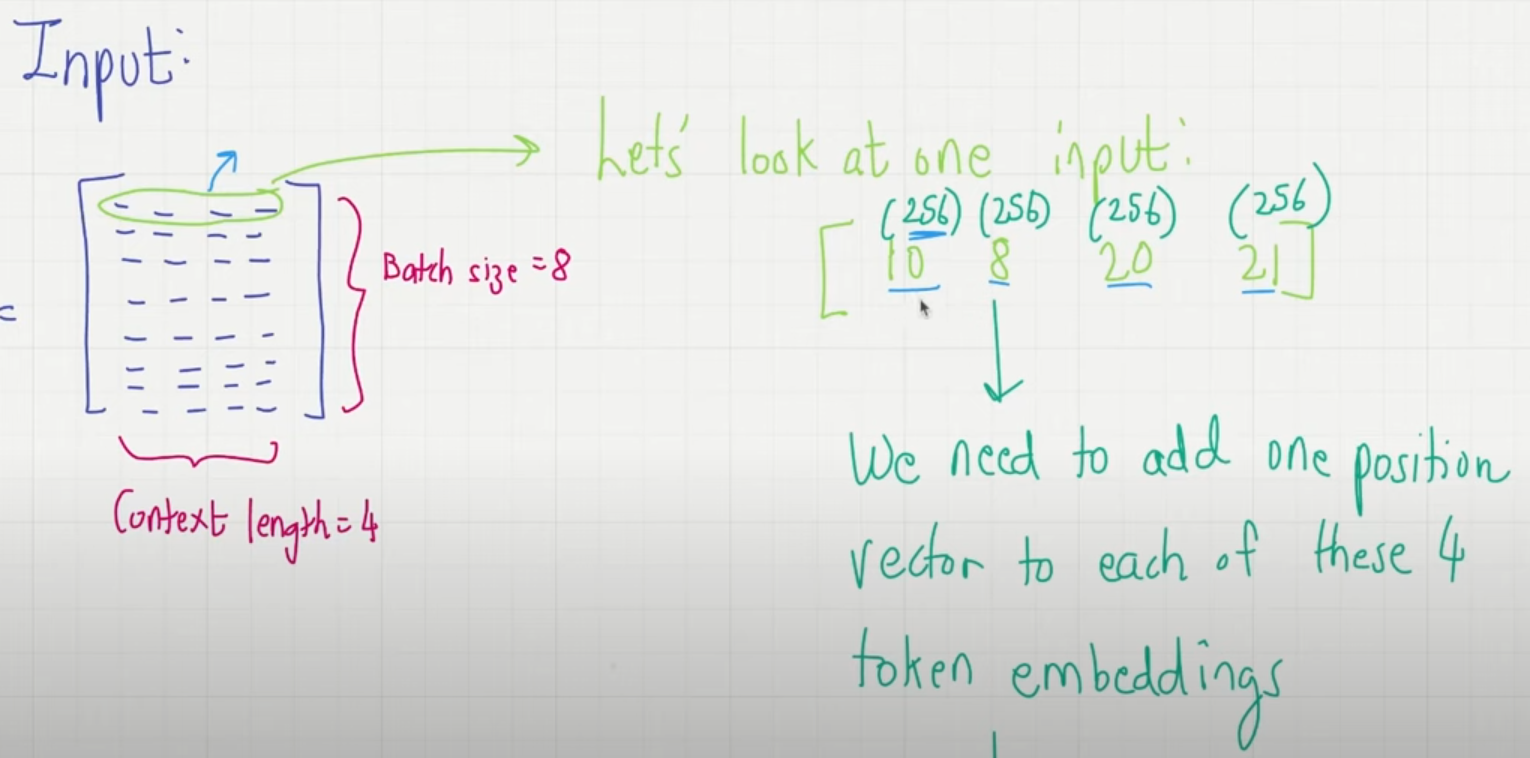

<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    Positional embedding vector will be added to each row of token embedding vector.
<div>

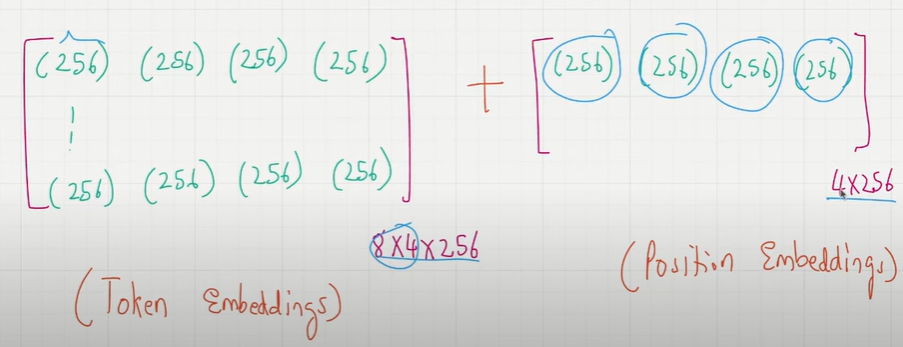

In [52]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


<div style="background-color: #B8B8FF; color: black; padding: 10px;">
    The input_embeddings we created are the embedded input examples that can now be processed by the main LLM modules
</div>